# Learning to pivot, part 2
## Unconditional vs conditional pivoting

Main paper: https://arxiv.org/abs/1611.01046

This example demonstrates difference between conditional and unconditional pivoting.

In [1]:
try:
    import mlhep2019
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip', 'install', 'git+https://github.com/yandexdataschool/mlhep2019.git'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )
    
    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))
    
    import mlhep2019

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from IPython import display

import numpy as np
import torch
import torch.utils.data

from mlhep2019.pivot import *

In [3]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

GeForce GTX 1080


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

    import warnings
    warnings.warn('Using CPU!')

## Toy data

In [5]:
NUISANCE_SIZE = 5
def get_data(size = 1024):
    nuisance_int = np.random.np.random.randint(0, NUISANCE_SIZE, size=(size, ))
    nuisance = nuisance_int.astype('float32') / 4
    
    xs = np.random.uniform(-1, 1, size=(size, ))
    ys = nuisance + np.random.normal(size=(size, )) * 0.05
    
    data = np.stack([xs, ys]).astype('float32').T
    
    labels = np.where((xs + 1) / 2 < ys, 1, 0).astype('float32')

    return data, labels, nuisance_int

In [6]:
data_train, labels_train, nuisance_train = get_data(size=1024)
data_test, labels_test, nuisance_test = get_data(size=128 * 1024)

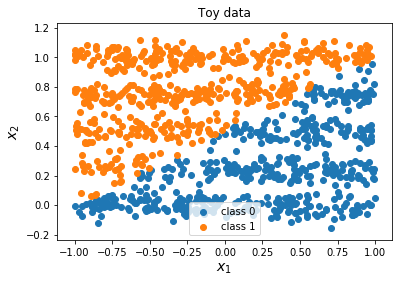

In [7]:
plt.scatter(data_train[labels_train < 0.5, 0], data_train[labels_train < 0.5, 1], label='class 0')
plt.scatter(data_train[labels_train > 0.5, 0], data_train[labels_train > 0.5, 1], label='class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Toy data')
plt.legend()
plt.show()

## Utility functions

In [8]:
xs, ys, grid = make_grid(data_train)

In [9]:
X_train, y_train, z_train = [
    torch.from_numpy(tensor).to(device)
    for tensor in (data_train, labels_train, nuisance_train)
]

X_test, y_test, z_test = [
    torch.from_numpy(tensor).to(device)
    for tensor in (data_test, labels_test, nuisance_test)
]

G = torch.from_numpy(grid).to(device)

In [10]:
dataset_test = torch.utils.data.TensorDataset(X_test, y_test, z_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1024, shuffle=False)

dataset_grid = torch.utils.data.TensorDataset(G)
dataloader_grid = torch.utils.data.DataLoader(dataset_grid, batch_size=1024, shuffle=False)

In [11]:
def get_predictions(model, loader):
    with torch.no_grad():
        return np.concatenate([
            torch.sigmoid(model(batch[0])).to('cpu').detach().numpy()
            for batch in loader
        ], axis=0)

test_predictions = lambda model: get_predictions(model, dataloader_test)
grid_predictions = lambda model: get_predictions(model, dataloader_grid)

## Unmodified classification

Here we define a simple classifier:
```
Input(2 units) -> DenseLayer(64 units) -> DenseLayer(32 units) -> DenseLayer(1 unit)
```

**Note:** we don't use any activation function for the output layer, however, at the same time with use `BCEWithLogitsLoss` loss as it is more computationally stable.

In [12]:
class Classifier(torch.nn.Module):
    def __init__(self, activation=torch.nn.Softplus()):
        super(Classifier, self).__init__()

        self.layer1 = torch.nn.Linear(2, 64)
        self.layer2 = torch.nn.Linear(64, 32)
        self.head = torch.nn.Linear(32, 1)

        self.activation = activation

    def forward(self, X):
        result = X
        result = self.activation(self.layer1(result))
        result = self.activation(self.layer2(result))

        return torch.flatten(
            self.head(result)
        )

In [13]:
classifier = Classifier().to(device)

In [14]:
loss_fn_classification = torch.nn.BCEWithLogitsLoss()

In [15]:
num_epoches = 128
num_batches = data_train.shape[0] // 32

losses = np.zeros(shape=(num_epoches, num_batches))

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

for i in tqdm(range(num_epoches)):
    for j in range(num_batches):
        optimizer.zero_grad()

        indx = torch.randint(0, data_train.shape[0], size=(32, ))
        X_batch, y_batch = X_train[indx], y_train[indx]
        
        predictions = classifier(X_batch)

        loss = loss_fn_classification(predictions, y_batch)
        losses[i, j] = loss.item()

        loss.backward()
        optimizer.step()

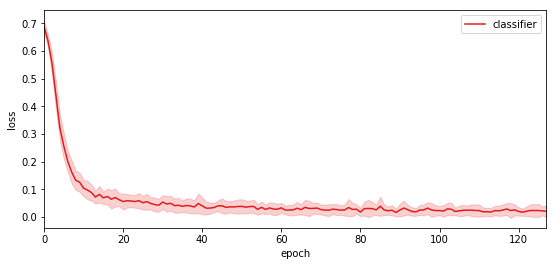

In [16]:
plot_losses(classifier=losses)

## Let's pivot

In order to make predictions of the classifier independent from nuisance parameters, an adversary is introduced.
The idea is similar to the main principle of GAN - seek for the solution that maximizes minimum of the adversary loss.

If classifier utilises information about nuisance parameters to make predictions, then its predictions are dependent on nuisance parameters. This information is most probably coming from dependencies between nuisance parameters and the training features, therefore, just excluding nuisance parameters from the training features is typically not enough.

Adversary is trained to predict nuisance parameters given output of the classifier. A dependency between nuisance parameters and predictions means that adversary is able to learn it (i.e. achieve minimum of the loss lower than loss of the constant). Maxumum of the minimum of the adversary loss is achieved only when there is not any dependencies between predictions and nusiances.


More formally, adversary loss is given by:
$$\mathcal{L}_{\mathrm{adv}}(\theta, \psi) = -\mathbb{E}_{x, z} \log P_\psi(z \mid f_\theta(x)) \to_\psi \min;$$
while the classifier is trained to minimize the following loss:
$$\mathcal{L}_{\mathrm{clf}} = \left[-\mathbb{E}_{x, y} \log P_\theta(y \mid x)\right] - \left[ \min_\psi \mathcal{L}_\mathrm{adv}(\theta, \psi)\right] \to_\theta \min;$$
where:
- $f_\theta$ and $P_\theta$ - classifier with parameters $\theta$ and probability distribution that corresponds to it;
- $P_\psi$ - probability distribution that corresponds to the output of adversary;

Note the minus sign before the second term in $\mathcal{L}_{\mathrm{clf}}$.

The training procedure is similar to that of GAN.


In [17]:
class Adversary(torch.nn.Module):
    def __init__(self, activation=torch.nn.Softplus()):
        super(Adversary, self).__init__()

        self.layer1 = torch.nn.Linear(1, 128)
        self.head = torch.nn.Linear(128, NUISANCE_SIZE)

        self.activation = activation

    def forward(self, X):
        result = X
        result = self.activation(self.layer1(result))

        return torch.squeeze(
            self.head(result),
            dim=1
        )

In [18]:
pivoted_classifier = Classifier().to(device)
adversary = Adversary().to(device)

In [19]:
loss_fn_pivoted_classification = torch.nn.BCEWithLogitsLoss()
loss_fn_adversary = torch.nn.CrossEntropyLoss()

**Warning:** be careful using optimizers with an internal state for adversarial optimization problems ($\max \min$ problems): almost all of the popular optimizers have an internal state  (except for SGD). After performing an optimization step for the generator, optimization problem for the adversary changes, thus, previously accumulated internal state might become invalid. This might lead to the noticable associlations in the learning curves. Alternatively, it might result in the generator (classifier in our case) and the adversary going in circles, which appears as if they have converged, which is especially difficult to detect; or collapse of the generator, as improper internal state of the discriminator optimizer slows its convergance. 

One might avoid these effects by setting learning rate of the adversary optimizer to a low enough value and/or train the adversary longer.

One can use any optimizer for the generator (classifier in our case), provided that the adversary has enough time to converge.

From practical experience, optimizers that use $l_\infty$ (adamax, AMSGrad etc) norm perform well. Nevertheless, when in doubt, use SGD for the adversary.

In [20]:
optimizer_pivoted_classifier = torch.optim.Adam(pivoted_classifier.parameters(), lr=1e-3)
optimizer_adversary = torch.optim.Adamax(adversary.parameters(), lr=1e-3)

In [21]:
num_epoches = 128
num_batches = data_train.shape[0] // 32

losses_clf = np.zeros(shape=(num_epoches, num_batches))
losses_adv = np.zeros(shape=(num_epoches, num_batches))

for i in tqdm(range(num_epoches)):
    for j in range(num_batches):
        ### training adversary
        for k in range(4):
            ### generating batch
            indx = torch.randint(0, data_train.shape[0], size=(32, ))
            X_batch, z_batch = X_train[indx], z_train[indx]
            
            optimizer_adversary.zero_grad()

            predictions = pivoted_classifier(X_batch)
            nuisance_predictions = adversary(torch.unsqueeze(predictions, dim=1))
            loss_adversary = loss_fn_adversary(nuisance_predictions, z_batch)
            
            loss_adversary.backward()
            optimizer_adversary.step()

        optimizer_pivoted_classifier.zero_grad()
        
        ### generating batch
        indx = torch.randint(0, data_train.shape[0], size=(32, ))
        X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]
        
        ### training classifier
        predictions = pivoted_classifier(X_batch)
        nuisance_predictions = adversary(torch.unsqueeze(predictions, dim=1))

        loss_classifier = loss_fn_pivoted_classification(predictions, y_batch)
        loss_adversary = loss_fn_adversary(nuisance_predictions, z_batch)

        losses_clf[i, j] = loss_classifier.item()
        losses_adv[i, j] = loss_adversary.item()

        joint_loss = loss_classifier - 2 * loss_adversary

        joint_loss.backward()
        optimizer_pivoted_classifier.step()

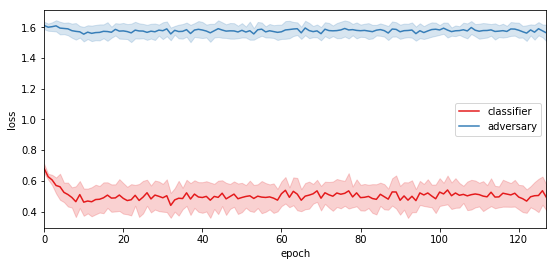

In [22]:
plot_losses(epoch=i, classifier=losses_clf, adversary=losses_adv)

If you look closely, you will see tiny (sometimes not tiny) associlations - note, how adamax stops them (at least, tries to). Try different optimizer (e.g. adam, adagrad) or decreasing number of adversary training steps for more pronounced effect.

### Conditional pivoting

Sometimes it is desirable to make predictions independent from the nuisance parameter within each class. Note, that this might still leave some dependency between nuisance and overall distribution of predictions.

In this case we make adversary **conditional**, which in practice means simply adding target labels as an input.

In [23]:
class ConditionalAdversary(torch.nn.Module):
    def __init__(self, activation=torch.nn.Softplus()):
        super(ConditionalAdversary, self).__init__()

        self.layer1 = torch.nn.Linear(2, 128)
        self.head = torch.nn.Linear(128, NUISANCE_SIZE)

        self.activation = activation

    def forward(self, X):
        result = X
        result = self.activation(self.layer1(result))

        return torch.squeeze(self.head(result), dim=1)

In [24]:
conditional_pivoted_classifier = Classifier().to(device)
conditional_adversary = ConditionalAdversary().to(device)

In [25]:
loss_fn_conditional_pivoted_classification = torch.nn.BCEWithLogitsLoss()
loss_fn_conditional_adversary = torch.nn.CrossEntropyLoss()

In [26]:
optimizer_conditional_pivoted_classifier = torch.optim.Adam(
    conditional_pivoted_classifier.parameters(), lr=1e-3
)
optimizer_conditional_adversary = torch.optim.Adam(conditional_adversary.parameters(), lr=1e-3)

In [27]:
num_epoches = 128
num_batches = data_train.shape[0] // 32

losses_clf = np.zeros(shape=(num_epoches, num_batches))
losses_adv = np.zeros(shape=(num_epoches, num_batches))

for i in tqdm(range(num_epoches)):
    for j in range(num_batches):

        ### training adversary
        for k in range(4):
            optimizer_conditional_adversary.zero_grad()
            
            indx = torch.randint(0, data_train.shape[0], size=(32, ))
            X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]

            predictions = conditional_pivoted_classifier(X_batch)
            
            nuisance_predictions = conditional_adversary(
                torch.stack([predictions, y_batch], dim=1)
            )
            loss_adversary = loss_fn_conditional_adversary(nuisance_predictions, z_batch)
            
            loss_adversary.backward()
            optimizer_conditional_adversary.step()

        optimizer_conditional_pivoted_classifier.zero_grad()
        
        indx = torch.randint(0, data_train.shape[0], size=(32, ))
        X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]
        
        ### training classifier
        predictions = conditional_pivoted_classifier(X_batch)
        nuisance_predictions = conditional_adversary(
            torch.stack([predictions, y_batch], dim=1)
        )

        loss_classifier = loss_fn_conditional_pivoted_classification(predictions, y_batch)
        loss_adversary = loss_fn_conditional_adversary(nuisance_predictions, z_batch)

        losses_clf[i, j] = loss_classifier.item()
        losses_adv[i, j] = loss_adversary.item()

        joint_loss = loss_classifier - 2 * loss_adversary

        joint_loss.backward()
        optimizer_conditional_pivoted_classifier.step()

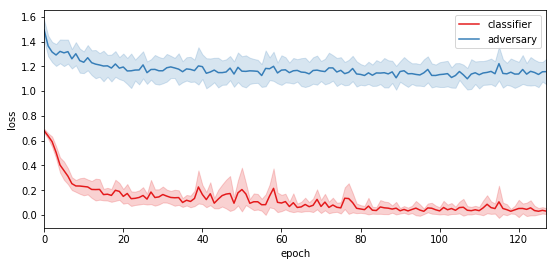

In [28]:
plot_losses(classifier=losses_clf, adversary=losses_adv)

## Results

In [29]:
from sklearn.metrics import roc_auc_score, log_loss

cross_entropy = lambda y, p: log_loss(y, p, eps=1e-6)
accuracy = lambda y, p: np.mean(np.where(y > 0.5, 1, 0) == np.where(p > 0.5, 1, 0))

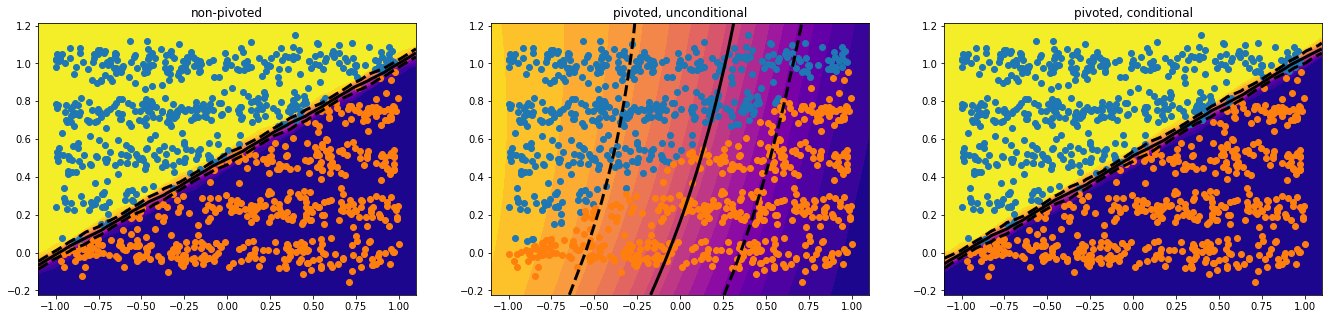

In [30]:
plt.subplots(nrows=1, ncols=3, figsize=(23, 5))

plt.subplot(1, 3, 1)
plt.title('non-pivoted')

draw_response(xs, ys, grid_predictions(classifier), data_train, labels_train)

plt.subplot(1, 3, 2)
plt.title('pivoted, unconditional')
draw_response(xs, ys, grid_predictions(pivoted_classifier), data_train, labels_train)

plt.subplot(1, 3, 3)
plt.title('pivoted, conditional')
draw_response(xs, ys, grid_predictions(conditional_pivoted_classifier), data_train, labels_train)

The following figure shows dependency between predictions and the nuisance parameter:
- each column correspond to a different model;
- rows correspond to nuisance parameter bins;
- each plot show distribution of model predictions within the corresponding nuisance bin.

- $\mathrm{MI}$ - (unconditional) mutual information between the nuisance parameter and model predictions.
- $\mathrm{MI}_i$ - mutual information between the nuisance parameter and model predictions **within** $i$-th class.

**Note**, that the following Mutual Information estimates migh be unreliable.

/home/mborisyak/dev/mlhep2019/mlhep2019/pivot/utils.py:30: RuntimeWarning: divide by zero encountered in log
  np.where(hist > 0, pmf * (np.log(pmf) - np.log(marginal_x)[:, None]), 0)


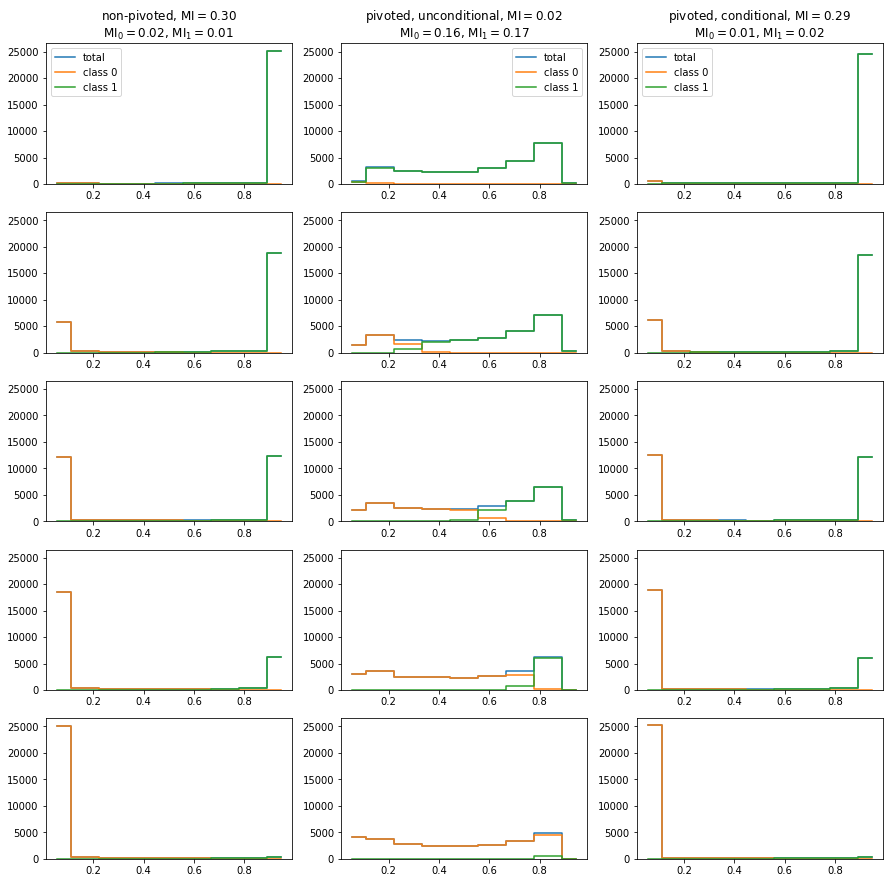

In [31]:
nuisance_prediction_hist([
        test_predictions(classifier),
        test_predictions(pivoted_classifier),
        test_predictions(conditional_pivoted_classifier)
    ],
    nuisance_test,
    labels=labels_test.astype('int'),
    names=['non-pivoted', 'pivoted, unconditional', 'pivoted, conditional']
)

Pivoted models tend to show worse (but flat) performance.
If pivoted models shows an increased performance in some regions, then most likely the model is biased (i.e. low capacity).

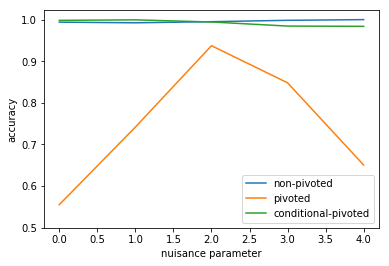

In [32]:
nuisance_metric_plot([
        test_predictions(classifier),
        test_predictions(pivoted_classifier),
        test_predictions(conditional_pivoted_classifier)
    ],
    labels_test, nuisance_test,
    metric_fn=accuracy, metric_name='accuracy',
    names=['non-pivoted', 'pivoted', 'conditional-pivoted'],
)

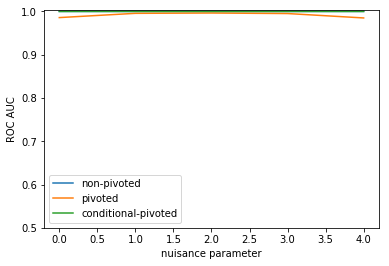

In [33]:
nuisance_metric_plot([
        test_predictions(classifier),
        test_predictions(pivoted_classifier),
        test_predictions(conditional_pivoted_classifier)
    ],
    labels_test, nuisance_test,
    metric_fn=roc_auc_score, metric_name='ROC AUC',
    names=['non-pivoted', 'pivoted', 'conditional-pivoted'],
)

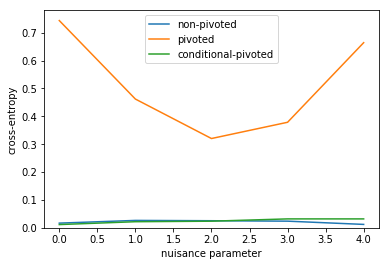

In [34]:
nuisance_metric_plot([
        test_predictions(classifier),
        test_predictions(pivoted_classifier),
        test_predictions(conditional_pivoted_classifier)
    ],
    labels_test, nuisance_test,
    metric_fn=cross_entropy, metric_name='cross-entropy', base_level=0.0,
    names=['non-pivoted', 'pivoted', 'conditional-pivoted'],
)